---

## **Introduction**

### **Q-Learning Method in Grid World**

This project implements **Q-Learning** in a GridWorld environment.

<br>

**Q-Learning** is a value-based method that learns the optimal policy by:
1. Iteratively updating **Q-values** (state-action values) using the **Bellman Equation**.

Q-Learning can be understood as the **sampling version of Exected SARSA**. Instead of selecting the action-value for the next state and next action, Q-Learning uses the action-value corresponding to the **maximum action in the next state** to update the current action-value.

In Q-learning, **regardless of the policy** used, as the number of iterations increases, the action values will eventually converge to $q_{*}$ (the optimal Q-values)(under the assumption that all state-action pairs are accessible). Therefore, **after enough iterations**, if only the actions that maximize the action values are chosen, this will **result in the optimal policy.**


This approach has several advantages:

- Like in **Temporal Difference (TD)** learning, updates can be performed before the episode ends.
- It uses an **off-policy** approach.
- It does **not require importance sampling**.

As discussed in [**Importance Sampling**](https://github.com/LeeJunho-AI/Reinforcement_Learning_Study/blob/main/08_Importance_Sampling.ipynb), when using importance sampling, the error increases as the probability distributions of the two policies differ. However, Q-Learning avoids this issue by not relying on importance sampling.

<br>

---

The grid world map is structured as follows:

- The game `starts` at the **Door** position.
- **Walls** are `impassable`.
- Passing through **Radiation** incurs a `penalty`.
- Reaching the **Treasure** position grants a `reward` and `ends the game`.

<img src="https://drive.google.com/uc?export=view&id=1UyixvvHu-hOYDmUtHK_ko5pjLUZWnAg1" alt="Gridworld" width="400">

<br>

---


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from collections import defaultdict
from matplotlib.patches import Rectangle, Polygon

class GridWorld:
  def __init__(self, target_policy, behavior_policy, epsilon = 0.1):
    self.target_policy = target_policy
    self.behavior_policy = behavior_policy
    self.epsilon = 0.1

    self.wall_map = np.array([
        ['wall',  0,     'wall',  0,     0],
        [0,       0,     0,       0,     'wall'],
        [0,       'wall', 0,      'wall', 'wall'],
        [0,       0,     0,       0,     'wall'],
        [0,       0,     0,       0,     0]])
    wall_indices = np.where(self.wall_map == 'wall')
    self.wall_cordinates = list(zip(wall_indices[0], wall_indices[1]))
    self.reward_map = np.array([
        [0, 0, 0, 0, 1],
        [-1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, -1, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])
    penalty_indices = np.where(self.reward_map < 0)
    self.penalty_cordinates = list(zip(penalty_indices[0], penalty_indices[1]))
    self.action_mean = {
        0: 'UP',
        1: 'DOWN',
        2: 'LEFT',
        3: 'RIGHT'}
    self.action_move = {
        0: (-1, 0),
        1: (+1, 0),
        2: (0, -1),
        3: (0, +1)}
    self.num_action = len(self.action_mean)
    self.action_arrows = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    self.start_state = (4, 0)
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9
    self.Qs = defaultdict(lambda: 0)
    self.history = []

  def get_action(self, state):
    actions_list = list(self.behavior_policy[state].keys())
    probs_list = list(self.behavior_policy[state].values())
    action = np.random.choice(actions_list, p = probs_list)

    return action

  def next_state(self, current_state, action):
    (y, x) = current_state
    (dy, dx) = self.action_move[action]
    next_state = (y + dy, x + dx)
    next_state = (
        max(0, min(self.grid_limit[0], next_state[0])),
        max(0, min(self.grid_limit[1], next_state[1])))
    if next_state in self.wall_cordinates:  # If the next state is a wall, stay in the current state
      next_state = current_state
    return next_state


  def target_policy_update(self, state):
    Qs_list = []
    for action in range(self.num_action):
      self.target_policy[state][action] = 0
      Qs_list.append(self.Qs[state, action])
    max_Qs = np.max(Qs_list)
    greedy_actions = np.where(Qs_list == max_Qs)[0]
    for greedy_action in greedy_actions:
      self.target_policy[state][greedy_action] += 1 / len(greedy_actions)

  def render_q(self, policy_show=True):
    fig, ax = plt.subplots(figsize=(10, 8))
    """
    Visualize the grid world with value function and optional policy arrows
    """

    all_q_values = [value for value in self.Qs.values()]
    vmin = min(all_q_values) if all_q_values else 0
    vmax = max(all_q_values) if all_q_values else 1

    colors = ["red", "white", "green"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    white_cmap = LinearSegmentedColormap.from_list('white_cmap', ['darkgray', 'darkgray'])
    norm = TwoSlopeNorm(vmin=vmin, vcenter=(vmin + vmax) / 2, vmax=vmax)

    ax.pcolormesh(np.flipud(np.zeros((self.width, self.height))), cmap = white_cmap, vmin=0, alpha=0.8)

    for y in range(self.height):
      for x in range(self.width):
        if (y, x) in self.wall_cordinates:
          plt.text(
                x + 0.5, self.height - y - 0.5, "Wall",
                ha="center", va="center", fontsize=20, color="purple", fontweight = 'bold')
          continue
        elif (y, x) == self.terminal_state:
          plt.text(
              x + 0.5, self.height - y - 0.5,
              "Goal",
              ha="center", va="center", fontsize=35, color="gold", fontweight = 'bold')
          continue
        elif (y, x) in self.penalty_cordinates:
          plt.text(
              x + 0.5, self.height - y - 0.65,
              "radiation",
              ha="center", va="center", fontsize=15, color="black", fontweight = 'bold')
        tx, ty = x, self.width - y - 1
        action_map = {
            0: ((0.5 + tx, 0.5 + ty), (tx + 1, ty + 1), (tx, ty + 1)),  # Up
            1: ((tx, ty), (tx + 1, ty), (tx + 0.5, ty + 0.5)),          # Right
            2: ((tx, ty), (tx + 0.5, ty + 0.5), (tx, ty + 1)),          # Down
            3: ((0.5 + tx, 0.5 + ty), (tx + 1, ty), (tx + 1, ty + 1)),  # Left
        }
        action_values = [self.Qs[((y, x), action)] for action in range(len(self.action_mean))]
        for action, color_value in zip(action_map.keys(), action_values):
          triangle_points = action_map[action]
          color = custom_cmap(norm(color_value))
          ax.add_patch(Polygon(triangle_points, facecolor=color, alpha=0.8, edgecolor = 'black', linewidth = 0.5))

          centroid_x = np.mean([p[0] for p in triangle_points])
          centroid_y = np.mean([p[1] for p in triangle_points])
          ax.text(
                centroid_x, centroid_y, f"{color_value:.2f}",
                ha="center", va="center", fontsize=10, color="black"
          )
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.gca().set_xticks(np.arange(self.width + 1), minor=True)
    plt.gca().set_yticks(np.arange(self.height + 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.7)
    plt.title("GridWorld Map, Q-Learning", fontsize=16)
    plt.show()


  def render_target_policy(self, policy_show=True):
    plt.figure(figsize=(10, 8))

    plt.pcolormesh((np.zeros((self.height, self.width))), cmap = 'Greys', vmin = 0, vmax = 1, alpha=0.8)

    for y in range(self.height):
      for x in range(self.width):
        if (y, x) in self.wall_cordinates:
          plt.text(
                x + 0.5, self.height - y - 0.5, "Wall",
                ha="center", va="center", fontsize=20, color="purple", fontweight = 'bold')
        else:
          if (y, x) == self.terminal_state:
            plt.text(
              x + 0.5, self.height - y - 0.5,
              "Goal",
              ha="center", va="center", fontsize=35, color="gold", fontweight = 'bold')
          else:
            if (y, x) in self.penalty_cordinates:
              plt.text(
                x + 0.2, self.height - y - 0.7,
                "radiation",
                ha="left", va="top", fontsize=13, color="black", fontweight = 'bold')
            if (y, x) == self.start_state:
              plt.text(
                x + 0.5, self.height - y - 0.7,
                "Start Here",
                ha="center", va="center", fontsize=15, color="blue", fontweight = 'bold')
            for action in self.target_policy[y, x]:
              if self.target_policy[y, x][action] != 0:
                plt.text(
                    x + 0.5, self.height - y - 0.5,
                    f"{self.action_arrows[action]}",
                    ha="center", va="center", fontsize=40, color="black")


    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    # Add grid lines manually
    plt.gca().set_xticks(np.arange(self.width + 1), minor=True)
    plt.gca().set_yticks(np.arange(self.height + 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.7)

    plt.title("GridWorld Map, Target Policy", fontsize=16)
    plt.show()


  def reset(self):
    self.start_state = (4, 0)
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9
    self.Qs = defaultdict(lambda: 0)
    self.ns = defaultdict(lambda: 0)
    self.history = []

  @property
  def height(self):
    return self.reward_map.shape[0]

  @property
  def width(self):
    return self.reward_map.shape[1]

---

## Policy Update Details

- The **behavior policy** was updated using the **random policy**.  
- The **target policy** was updated using a **greedy method**.  
- The value of `epsilon` used is **0.1**.  

---

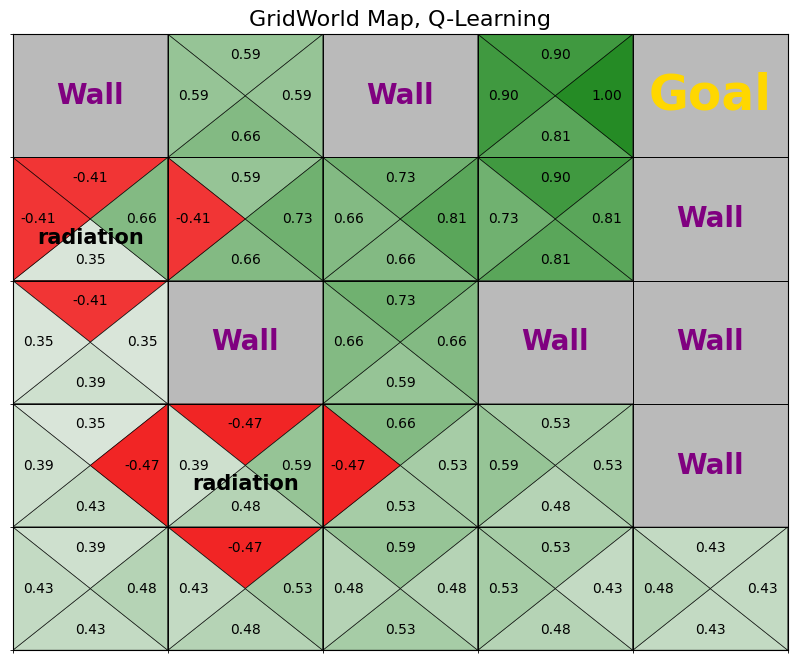

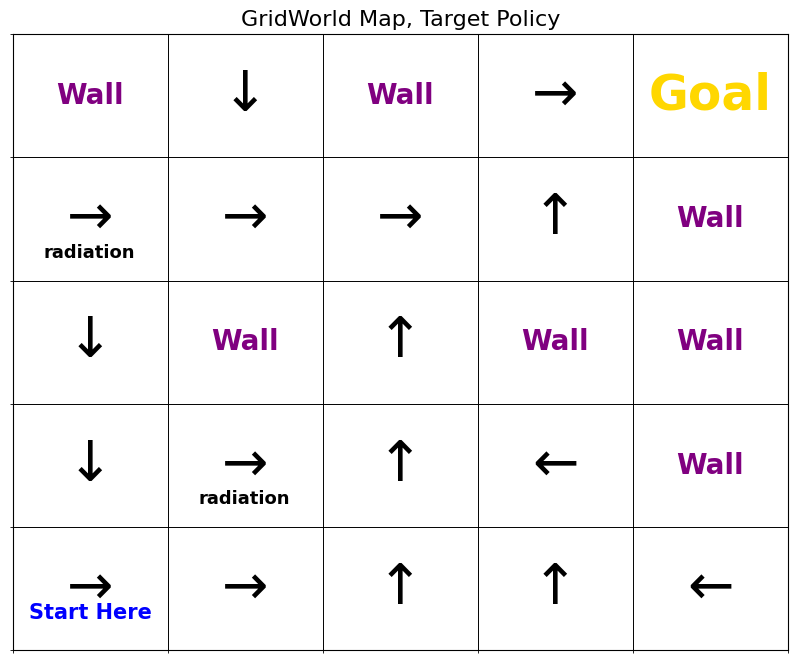

In [4]:
np.random.seed(7)

behavior_policy = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
target_policy = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})

alpha = 0.1
epsilon = 0.1

game = GridWorld(target_policy, behavior_policy, epsilon)
total_episode = 100

for _ in range(total_episode):
  current_state = game.start_state
  while True:
    action = game.get_action(current_state)
    next_state = game.next_state(current_state, action)
    reward = game.reward_map[next_state]

    Qs = [game.Qs[next_state, action] for action in range(len(behavior_policy))]
    max_Qs = np.max(Qs)

    target = reward + game.gamma * max_Qs
    game.Qs[current_state, action] += alpha * (target - game.Qs[current_state, action])
    game.target_policy_update(current_state)

    if next_state == game.terminal_state:
      break

    current_state = next_state

game.render_q()
game.render_target_policy()

---

## **Conclusion**

We sampled data using a **random policy** that selects all actions **with equal probability** and did **not** use **importance sampling**. However, from the above results, we can **confirm that it still converges to the optimal policy**.

Moreover, in the above case, the **state-action set was small**, so we used a **random policy** as the **behavior policy**. However, if the **state-action set is large**, using an **ε-greedy policy** as the behavior policy can be **more efficient**. This is because updates will occur **less frequently** for sets that are **relatively less relevant to the optimal policy**, leading to a **more efficient** convergence to the **optimal policy**.


<br>

---